<a href="https://colab.research.google.com/github/kenanEkici/COVID19-fake-tweet-detection-XAI/blob/main/Masterproef_HCI_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Kenan Ekici

# 1) Introduction

<img src="https://www.memesmonkey.com/images/memesmonkey/d0/d017cba8767eba32edc7e43e6132d4a7.jpeg" />

# 2) Imports

In [1]:
#lime
!pip install lime -q
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

# for hydrating tweet ids
!pip install twarc -q

#utils
import os
import re
import json
import random
from datetime import datetime
from shutil import copyfile
import string
from string import ascii_letters
from collections import Counter, defaultdict

#math, data
import math
import numpy as np
from numpy import inf
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import  word_tokenize 
from textblob import TextBlob
from sklearn.utils import shuffle

#plots, image
import cv2
from skimage import io
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

#ml, nlp
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

     |████████████████████████████████| 276kB 5.7MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 3) Collecting raw data


The first step is to search for labeled datasets (labeled as misinformation or not) of Tweets and news articles that might contain false claims or other misleading information about COVID-19. We will need this dataset to build a supervised machine learning classifier to detect Tweets that contain misinformation. The first source that was found contains hundreds of Tweet ID's, which are a reference to the actual Tweets on Twitter. The second and third source contain both Tweets, news articles and website claims. The news articles and claims will be an additional source to extract language features that may be important to classify fake news. We are interested in both objective or subjective claims and news articles. The Tweets are more rich in information as they they come with more features and can contain any kind of content unlike news articles which only contain news. Unfortunately due to privacy reasons, the Tweets have been compressed to their ID and the ID of the users that posted the Tweet. This means that we will need a third party library such as Twarc in order to collect the actual Tweets which the ID's reference to. In the context of Twitter this is also referred to as "rehydration". The last source contains ID's of users that were labeled as either social bot or real accounts. We need this source as we will train a supervised classifier for detecting social bots. We discussed that these could be an important source and indicator of misinformed Tweets. These must also be rehydrated using the third party library.

Source #1: https://github.com/firojalam/COVID-19-tweets-for-check-worthiness (Downloaded 06-10-2020)

Source #2: https://github.com/cuilimeng/CoAID (Downloaded 06-10-2020)

Source #3: https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv (Downloaded 06-10-2020)

Source #4: http://mib.projects.iit.cnr.it/dataset.html (Downloaded 06-10-2020)

In [2]:
# for convenience, we will download a bundle of all the sources from a Google drive endpoint
# if this endpoint does not work, please contact the author

# we dump all the raw files to the folder RawData
!rm -rf RawData
!rm -rf Junk
!rm -rf Classified
!gdown https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
!unzip RawData.zip
!rm RawData.zip

Downloading...
From: https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
To: /content/RawData.zip
8.51MB [00:00, 51.9MB/s]
Archive:  RawData.zip
   creating: RawData/
  inflating: RawData/covid19_infodemic_english_data.tsv  
  inflating: RawData/corona_fake.csv  
  inflating: RawData/cresci_fake_users.txt  
   creating: RawData/07-01-2020/
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19.csv  
  inflati

## Source 1

The first source contains COVID-19 related Tweets that have been extensively labeled by a community. The Tweets are categorized based on the answers they provide to the following questions:

- Q1: "Does the tweet contain a verifiable factual claim?"
- Q2: "To what extent does the tweet appear to contain false information?"
- Q3: "Will the tweet’s claim have an effect on or be of interest to the general public?"
- Q4: "To what extent does the tweet appear to be harmful to society, person(s), company(s) or product(s)?"
- Q5: "Do you think that a professional fact-checker should verify the claim in the tweet?"
- Q6: "Is the tweet harmful for society and why?"
- Q7: "Do you think that this tweet should get the attention of a government entity?"

The provided TSV file is loaded as a dataframe. The dataframe contains the ID and textual content of the Tweet as well as columnn that each represent one of the questions above. The columns (questions) have a variety of possible answers (refer to Github source 1). Thus, it is possible to filter out some of the Tweets from the dataframe that are not relevant. For the final misclassification Tweet dataset, we add every Tweet which contains the following answers: "yes" to question 1, "yes, probably or definitely contains false info" to question 2, and "yes, either urgent or not urgent" to question 5. 

In [3]:
df = pd.read_csv('RawData/covid19_infodemic_english_data.tsv', sep='\t')

In [4]:
df_1 = df.loc[df['q1_label'] == 'yes']
df_1 = df.loc[(df['q2_label'] == '4_yes_probably_contains_false_info') | (df['q2_label'] == '5_yes_definitely_contains_false_info')]
df_1 = df.loc[(df['q5_label'] == 'yes_not_urgent') | (df['q5_label'] == 'yes_very_urgent')]
df_1.head()

tweet_id  ...                    q7_label
4   1241447017945223169  ...          no_not_interesting
11  1240676575168921600  ...       yes_blame_authorities
13  1240768501452697600  ...       yes_blame_authorities
15  1241337295606657033  ...  yes_discusses_action_taken
19  1241057919128526856  ...  yes_discusses_action_taken

[5 rows x 9 columns]

In [5]:
# We only need the Tweet ID's
tweets_fake_1 = df_1['tweet_id']
print("This dataset contains",df_1.shape[0], "Tweet ID's")

This dataset contains 160 Tweet ID's


## Source 2

https://arxiv.org/pdf/2006.00885.pdf

The second source CoAID contains both factual and misleading COVID-19 claims from websites and news articles. It also contains Tweets that make COVID-19 related claims or share related news. The factual articles and claims have collected from reliable media outlets and websites such as WHO's official website.The fake news articles have been collected from fact-checking websites such as PolitiFact. The Tweets were queried based whether they contained news titles of misleading or factual news and thus labeled accordingly. The paper also presents important insights on the CoAID dataset such as the frequency of the hashtags used in both fake and real news and a list common claims. For our dataset, we collect only the labeled claims, news articles, and Tweets (both news and claims) but not the user replies. 

In [6]:
def read_content_from_folder(dir_name): 
  fake_claims = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19.csv'))['title']
  fake_claims = pd.DataFrame({'content':fake_claims})
  fake_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19_tweets.csv'))['tweet_id']
  fake_news =  pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19.csv'))[['title', 'content']]
  fake_news['content'] = fake_news['title'].replace(np.nan, '', regex=True) + ' ' + fake_news['content'].replace(np.nan, '', regex=True)
  fake_news = pd.DataFrame({'content':fake_news['content']})
  fake_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19_tweets.csv'))['tweet_id']

  real_claims = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19.csv'))['title']
  real_claims = pd.DataFrame({'content':real_claims})
  real_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19_tweets.csv'))['tweet_id']
  real_news =  pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19.csv'))[['title', 'content']]
  real_news['content'] = real_news['title'].replace(np.nan, '', regex=True) + ' ' + real_news['content'].replace(np.nan, '', regex=True)
  real_news = pd.DataFrame({'content':real_news['content']})
  real_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19_tweets.csv'))['tweet_id']

  return [fake_claims, fake_claims_tweets, fake_news, fake_news_tweets, real_claims, real_claims_tweets, real_news, real_news_tweets]

l1 = read_content_from_folder('RawData/05-01-2020/')
l2 = read_content_from_folder('RawData/07-01-2020/')

all_dfs = []

# merging two lists, reset index
for i, dataframe in enumerate(l1):
  all_dfs.append(dataframe.append(l2[i], ignore_index=True))

fc, fct, fn, fnt, rc, rct, rn, rnt = all_dfs

In [7]:
# join previous fake claims tweet id's with new collectd id's
fct = tweets_fake_1.append(fct, ignore_index=True)

## Source 3

The third source contains around 500 factual and 500 misleading news articles collected by the author of https://towardsdatascience.com/covid-fake-news-detection-with-a-very-simple-logistic-regression-34c63502e33b, senior data scientist Susan Li. We collect both the content and the title of the articles and combine them in one column. 

In [8]:
# code from: https://github.com/susanli2016/NLP-with-Python/blob/master/Fake_News_LogReg.ipynb
df = pd.read_csv('RawData/corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5,'label'] = 'FAKE'
df.loc[15,'label'] = 'TRUE'
df.loc[43,'label'] = 'FAKE'
df.loc[131,'label'] = 'TRUE'
df.loc[242,'label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

df['title_text'] = df['title'] + ' ' + df['text']
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text
    
df['title_text'] = df['title_text'].apply(preprocessor)
df['label'].value_counts()

TRUE    586
FAKE    578
Name: label, dtype: int64

In [9]:
df_t = pd.DataFrame({'content':df.loc[df['label']=='TRUE','title_text']})
df_f = pd.DataFrame({'content':df.loc[df['label']=='FAKE','title_text']})

In [10]:
fn = fn.append(df_f, ignore_index=True)
rn = rn.append(df_t, ignore_index=True)

## Source 4

The last dataset contains a list of Twitter user ID's of both bots and real accounts which have been labeled through CrowdFlower, a crowdsourcing platform. This data will be necessary to train the social bot classifier in a later section. Due to privacy reasons, the dataset may not be distributed. You can request the dataset from the authors or use another source. For the latter case, please replace the file paths below with the path of a text file containing a list of Twitter user ID's. 

In [11]:
bot_user_id = pd.read_csv("RawData/cresci_fake_users.txt", header=None)
real_user_id = pd.read_csv("RawData/cresci_real_users.txt", header=None)

## Raw dataframes

We now have collected all of the necessary data. Although the claims and articles are raw strings, the Tweets are ID's (due to privacy reasons) and thus must be fetched explictely from the Twitter API. In the next section, we will use Twarc to fetch the Twitter level data.   

In [12]:
dataframes = [("fake_claims", fc), ("fake_claims_tweets", fct), ("fake_news", fn), ("fake_news_tweets", fnt), 
              ("real_claims", rc), ("real_claims_tweets", rct), ("real_news", rn), ("real_news_tweets", rnt),
              ("bot_users", bot_user_id), ("real_users", real_user_id)]

[print(i[0], len(i[1])) for i in dataframes]
print()

fake_claims 28
fake_claims_tweets 644
fake_news 1416
fake_news_tweets 10416
real_claims 338
real_claims_tweets 7795
real_news 3303
real_news_tweets 141548
bot_users 3455
real_users 3474



# 4) Rehydrating Tweet ID'S

We will use Twarc to rehydrate the Twitter ID's that we collected in the previous section. Twarc will rehydrate the ID's and collect the Twitter level data. This includes the Tweet and the data of the user that posted the Tweet. We will rehydrate both the Tweet ID's and the user ID's that we have collected in the previous section. In order to use Twarc, you will need a Twitter developer key and access token which you can request from the Twitter developer API.  


In [13]:
# you can ignore this variable
# this will always be False if you are not the author of this notebook
author = True

# for temps files
!mkdir Junk

if not author:
  tweets_fake = fnt.append(fct, ignore_index=True)
  tweets_true = rnt.append(rct, ignore_index=True)

  # we combine all found tweet IDS
  print(len(tweets_fake), len(tweets_true))

  with open("Junk/tweets_fake.txt", "w") as f:
      for line in tweets_fake:
          f.write(str(line)+"\n") 

  with open("Junk/tweets_real.txt", "w") as f:
      for line in tweets_true:
          f.write(str(line)+"\n") 

  copyfile("RawData/cresci_fake_users.txt", "Junk/cresci_fake_users.txt")
  copyfile("RawData/cresci_real_users.txt", "Junk/cresci_real_users.txt")

  # Need a Twitter dev account and keys
  !twarc configure

  !mkdir Classified

  !twarc hydrate Junk/tweets_fake.txt > Classified/tweets_fake.jsonl
  !twarc hydrate Junk/tweets_real.txt > Classified/tweets_real.jsonl
  !twarc users Junk/cresci_real_users.txt > Classified/real_users.jsonl
  !twarc users Junk/cresci_fake_users.txt > Classified/fake_users.jsonl
else:
  # only the author can retrieve the prepopulated data from a personal Google drive folder
  !gdown https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
  !unzip Classified.zip
  !rm Classified.zip

def read_json(filename):
  tweets = []
  with open(filename) as f:
    for line in f:
      tweets.append(json.loads(line))
  return tweets  

Downloading...
From: https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
To: /content/Classified.zip
68.1MB [00:01, 66.9MB/s]
Archive:  Classified.zip
   creating: Classified/
  inflating: Classified/tweets_real.jsonl  
  inflating: Classified/fake_users.jsonl  
  inflating: Classified/real_users.jsonl  
  inflating: Classified/tweets_fake.jsonl  


As you can verify below, after collecting the Tweets from the API, the amount of entries are a lot less than the actual raw data. This is because some of the Tweets (and users) may have been deleted and thus resulted into empty entries.

In [14]:
# these contain both Tweet data and user data
tweets_fake_ = read_json('Classified/tweets_fake.jsonl')
tweets_real_ = read_json('Classified/tweets_real.jsonl')

# these only contain user data
users_fake_ = read_json('Classified/fake_users.jsonl')
users_real_ = read_json('Classified/real_users.jsonl')

#sanity check
print(len(tweets_fake_))
print(len(tweets_real_))
print(len(users_fake_))
print(len(users_real_))

10165
142761
2804
2892


# 5) Feature selection and mining

## Feature selection

Now that we have collected the Tweets and users in JSON format, we can determine which columns we want to keep for the final dataset. After all, the API returns a large set of columns and features. Some of these feature are not necessary for building the classifiers. We have defined two helper functions to convert the JSON files of both Tweets and users to a Pandas dataframe. This will be easier to work with when doing analysis. We will also simultaneously filter the columns that are redundant. 

All the features and their descriptions can be found at:

- Users: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user

- Tweets: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

In [15]:
tweet_columns = ["id", "source", "full_text", "retweet_count", "favorite_count", "possibly_sensitive", "entities", "created_at"]
user_columns = ["id", "name", "screen_name", "has_extended_profile", "location", "description", "url", "protected", "followers_count", "friends_count", "listed_count", "created_at", "favourites_count", "verified", "statuses_count", "profile_image_url_https", "default_profile", "default_profile_image"]

# this function will be used to convert the json files that contain
# both the tweet level and user level data to a Pandas dataframe
def json_to_dataframe(json, amount):
  tweets = []
  users = []
  for i, t in enumerate(json):
    tweet_row = []
    user_row = []
    for _, tc in enumerate(tweet_columns):
      if (tc == "possibly_sensitive"):
        if "possibly_sensitive" in t:
          tweet_row.append(t["possibly_sensitive"])
        else:
          tweet_row.append(False)
      else:
        tweet_row.append(t[tc])    
    for _, tu in enumerate(user_columns):
      user_row.append(t['user'][tu])
    tweets.append(tweet_row)
    users.append(user_row)
  df_t = pd.DataFrame(data= tweets, columns=tweet_columns)
  df_u = pd.DataFrame(data=users, columns=user_columns)

  return df_t[0:amount], df_u[0:amount]

# this function will be used to convert only the json files
# that contain user level data to a Pandas dataframe
def user_json_to_dataframe(json):
  users = []
  for i, u in enumerate(json):
    user_row = []
    for _, tu in enumerate(user_columns):
      user_row.append(u[tu])
    users.append(user_row)
  df_u = pd.DataFrame(data=users, columns=user_columns)
  return df_u

## Data mining

The literature and related work proposes a variety of techniques to improve classification of anomalous behavior such as social bots or fake news. Data mining is such a technique in which new knowledge is inferred from existing data. We will use this technique to generate new columns from the existing ones that were retrieved from the API. An example of these features are username length, likes and age ratio or the ratio of friends to followers. The following functions will be used to mine such features. 

In [16]:
#https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7

#https://medium.com/pew-research-center-decoded/detecting-subjectivity-and-tone-with-automated-text-analysis-tools-5f0e662224b8

def calculate_is_subjective(mined_data):
  def textblob_adj(text):
      blobed = TextBlob(text)
      counts = Counter(tag for word,tag in blobed.tags)
      adj_list = []
      adv_list = []
      adj_tag_list = ['JJ','JJR','JJS']
      adv_tag_list = ['RB','RBR','RBS']
      for (a, b) in blobed.tags:
        if b in adj_tag_list:
          adj_list.append(a)
        elif b in adv_tag_list:
          adv_list.append(a)
        else:
          pass
      return adj_list, adv_list, counts['JJ']+counts['JJR']+counts['JJS'], counts['RB']+counts['RBR']+counts['RBS'], counts['NNP']
    
  mined_data['subjective'] = 0
  mined_data['n_nnp'] = 0

  for i, k in mined_data.iterrows():
    adj, adv, adj_c, adv_c, nnp_c = textblob_adj(k['full_text'])
    mined_data['n_nnp'].loc[i] = nnp_c
    if (adj_c >= 2 and adv_c >=1):
      mined_data['subjective'].loc[i] = 1
  return mined_data

def preprocess_tweet(mined_data):
  def add_amount_features(col_name, char):
    mined_data[col_name] = 0
    for i, s in enumerate(mined_data['full_text']):
      n_q = 0
      for k in s:
        if (k == char):
          n_q +=1
      mined_data[col_name].loc[i] = n_q

  add_amount_features('n_question', '?')
  add_amount_features('n_exclaim', '!')
  add_amount_features('n_hash', '#')
  mined_data['n_uppercase'] = mined_data['full_text'].str.findall(r'[A-Z]').str.len()
  mined_data['length'] = mined_data['full_text'].str.len()
  mined_data['created_at_tweet'] = mined_data['created_at']
    
  mined_data['has_link'] = False
  for i, s in enumerate(mined_data['full_text']):
    mined_data.loc[i, 'has_link'] = ('t.co' in s) or ('http' in s)
  mined_data['has_link'] = mined_data['has_link'].astype(int)
  mined_data['possibly_sensitive'] = mined_data['possibly_sensitive'].astype(int)
  mined_data = calculate_is_subjective(mined_data)

  return mined_data

def preprocess_users(mined_data, bot=False):
  
  mined_data['bio_length'] = mined_data['description'].apply(len)
  mined_data['username_length'] = mined_data['screen_name'].apply(len)
  mined_data['name_length'] = mined_data['name'].apply(len)
  date_format = "%a %b %d %H:%M:%S +%f %Y" 
  mined_data['age_account_days'] = 0
  for i, r in enumerate(mined_data['created_at']):
    a = None
    if (bot):
      a = datetime(2017, 4, 30)
    else: 
      a = datetime.now()
    b = datetime.strptime(r, date_format)
    mined_data['age_account_days'].iloc[i] = (a - b).days

  mined_data['created_at_user'] = mined_data['created_at']
  
  mined_data['friends_count'] = mined_data['friends_count'].replace([0],1)
  mined_data['followers_friends_ratio'] = (mined_data['followers_count'] / mined_data['friends_count'])
  mined_data['age_account_days'] = mined_data['age_account_days'].replace([0],1)
  mined_data['likes_age_ratio'] = (mined_data['favourites_count'] / mined_data['age_account_days'])

  mined_data['verified'] = mined_data['verified'].astype(int)
  mined_data['has_location'] = mined_data['location'] != ''
  mined_data['has_location'] = mined_data['has_location'].astype(int)
  mined_data['default_profile_image'] = mined_data['default_profile_image'].astype(int)
  mined_data['default_profile'] = mined_data['default_profile'].astype(int)
  mined_data['protected'] = mined_data['protected'].astype(int)
  mined_data['has_url'] = mined_data['url'].astype(str) != "None"
  mined_data['has_url'] = mined_data['has_url'].astype(int)
 
  return mined_data

During the retrieval of the raw data, it was rather evident that there was more data of normal behavior (factual news), then there is of anomalous behavior (fake news). This is a known problem in supervised classification of anomalous behavior which is due the fact that anomalies occur less often. Below, we make sure that we maintain a balanced dataset for training. 

In [17]:
# these contain fake/real news and claims of Twitter users 
# as well as the users that posted them
amount = 10000
tweets_fake, tweets_fake_users = json_to_dataframe(tweets_fake_, amount)
tweets_real, tweets_real_users = json_to_dataframe(tweets_real_, amount)
tweets_fake = preprocess_tweet(tweets_fake)
tweets_real = preprocess_tweet(tweets_real)

# we preprocess the previous users and mine relevant features
tweets_fake_users = preprocess_users(tweets_fake_users)
tweets_real_users = preprocess_users(tweets_real_users)

# these will be used to train the social bot detector 
bots = preprocess_users(user_json_to_dataframe(users_fake_), True)
non_bots = preprocess_users(user_json_to_dataframe(users_real_), True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Finalized dataset

We have now collected all the required data and mined the features that are necessary for further analysis and the development of the supervised classifiers. However, before we develop the classifiers, we must do analyze the dataset in order to gain an insight on both the features and their correlation with the target labels that we aim to predict. This process will help to determine which features are useful and which are not.

**The final dataset that we will continue using consists of:**



In [18]:
fake_news_articles = fn
real_news_articles = rn
print(len(fake_news_articles), "Fake and", len(real_news_articles), "real news articles (text)")

fake_claims = fc
real_claims = rc
print(len(fake_claims), "fake and", len(real_claims), "real website claims (text)")

print(len(tweets_fake), "fake and", len(tweets_real), "real news and claims (tweets)")

print("The corresponding", len(tweets_fake_users)+len(tweets_real_users) ,"users that posted these fake real claims and news (users)")

#print("The corresponding", len(tweets_fake_users_study)+len(tweets_real_users_study) ,"users that posted these fake real claims and news (users) - version for user study")
 
print(len(bots), "bots and", len(non_bots), "real users (users)")

1416 Fake and 3303 real news articles (text)
28 fake and 338 real website claims (text)
10000 fake and 10000 real news and claims (tweets)
The corresponding 20000 users that posted these fake real claims and news (users)
2804 bots and 2892 real users (users)


# 6) Data analysis

In this section, we will analyze the dataset we have collected previously. The purpose of analysis is to find features that correlate with misinformation. We will use these features in order to develop a misinformation classifier in a later section. We will explore all the features that were deemed important by literature. These include features that were mined in the data mining step. We divide this section into both misinformation and social bot. In the latter, we will analyze whether some users have specific features that correlate with them being a social bot. As we know from literature, social bots can be used to spread misinformation and can thus be an important indicator in the detection of misinformation.   

## Misinformation

We must analyze the data to find features that are highly correlated with the target label (fake or not fake news). In this section, we will analyze the Twitter data which consists of both the Tweet level data and user level data. In order to do this, we explicitly label fake news (and claims) with the number <b>one</b>, and the factual news (and claims) with <b>zero</b>.  

In [19]:
# 20K users 
tweets_users = (tweets_fake_users.append(tweets_real_users, ignore_index=True))
# 20K tweets
tweets = (tweets_fake.append(tweets_real, ignore_index= True))

# 20K corresponding labels
y = np.concatenate((np.ones(len(tweets_fake)), np.zeros(len(tweets_real))))

tweets_and_users = pd.concat([tweets, tweets_users.drop(["id"], axis=1)], axis=1)
tweets_and_users['label'] = y

### Social impact

The first analysis will be that of social impact as each Tweet contains both the amount of retweets and favorites. Below, we plot the "social impact" that each Tweet has on a scatterplot. Hereby, we can confirm that some misinformation Tweets are spread and favorited significantly more than Tweets that are not labeled as such. However, when we inspect the scatterplot more closely (second figure), we can see that it becomes harder to distinguish both labels. While there is indeed a significant "social impact" difference on large scale, it does not necessarily mean that it is a good feature. 

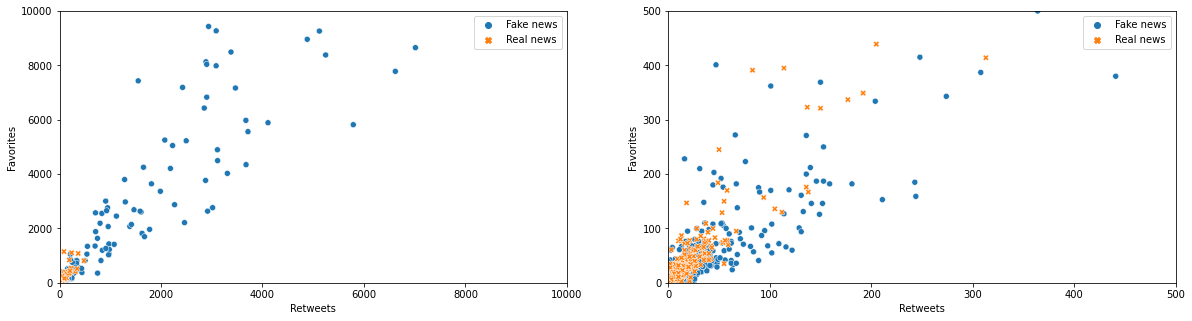

In [20]:
def get_hue(y):
  k = []
  for o in y:
    if o == 0:
      k.append("Real news")
    else:
      k.append("Fake news")
  return k

fig, axs = plt.subplots(ncols=2, figsize=(20,5))
sns.scatterplot(data=tweets_and_users, x="retweet_count", y="favorite_count", style=get_hue(y), hue=get_hue(y), ax=axs[0])
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,10000)
axs[0].set_xlabel("Retweets")
axs[0].set_ylabel("Favorites")
ax = sns.scatterplot(data=tweets_and_users, x="retweet_count", y="favorite_count", style=get_hue(y), hue=get_hue(y), ax=axs[1])
axs[1].set_xlim(0,500)
axs[1].set_ylim(0,500)
axs[1].set_xlabel("Retweets")
axs[1].set_ylabel("Favorites")
plt.savefig('Junk/socialimpact.jpg')
print()

We will plot the correlation matrix in order to see whether "social impact" has a statistical significance, that is, whether it can be considered useful to distinguish misinformation. 

In [21]:
# helper function to plot the correlation matrix
def plot_correlation_matrix(d):
  sns.set_theme(style="white")
  corr = d.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(5, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
  

We can see that the retweet count and favorite count are (strongly) positively correlated. We can easily confirm this when considering the scatterplot above. Although "retweet_count" and "favorite_count" show positive correlation, it is not very convincing. We thus must look at other features that may be more useful to distinguish misinformation.   

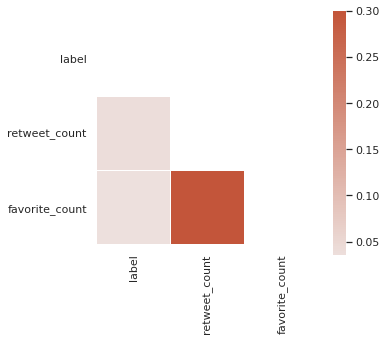

In [22]:
plot_correlation_matrix(tweets_and_users[["label","retweet_count", "favorite_count"]])

### Tweet text

We also consider linguistic features which might be strong indicators for fake news. These features are:
- length of the tweet
- number of question marks, exclamation marks, uppercased characters, number of hashtags, number of proper nouns
- whether the contains a URL
- whether the Tweet is subjective or objective
- marked by Twitter as sensitive

The hypothesis is that an exaggerated use of certain linguistic features might be more typical for Tweets that contain misinformation. 

We can see that the distribution plots below do not show notable differences between the linguistic features of fake and real news Tweets except for the last plot indicating that fake news might include more uppercases than baseline behavior.  

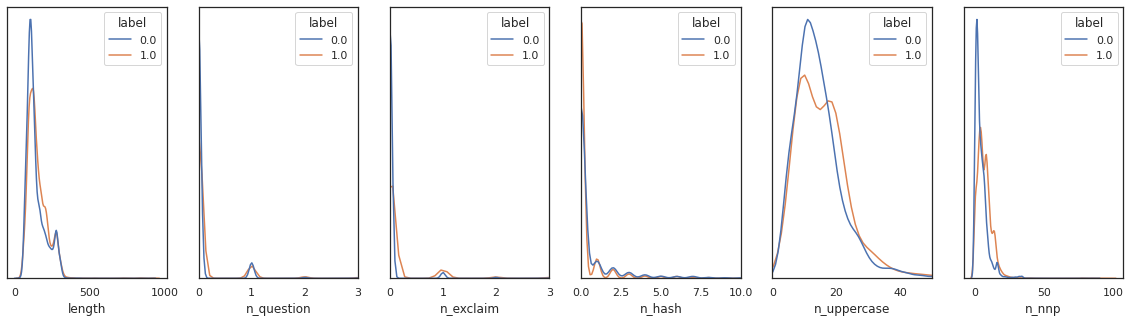

In [23]:
fig, axs = plt.subplots(ncols=6, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)

sns.kdeplot(data=tweets_and_users, x="length", hue="label", ax=axs[0])
sns.kdeplot(data=tweets_and_users, x="n_question", hue="label" ,ax=axs[1])
axs[1].set_xlim(0,3)
sns.kdeplot(data=tweets_and_users, x="n_exclaim", hue="label", ax=axs[2])
axs[2].set_xlim(0,3)
sns.kdeplot(data=tweets_and_users, x="n_hash", hue="label", ax=axs[3])
axs[3].set_xlim(0,10)
sns.kdeplot(data=tweets_and_users, x="n_uppercase", hue="label", ax=axs[4])
axs[4].set_xlim(0,50)
sns.kdeplot(data=tweets_and_users, x="n_nnp", hue="label", ax=axs[5])

print()

Below, we can verify whether these features can be useful to distinguish misinformation. We can clearly see the positive correlation in linguistic features with each other. Although some linguistic features are (weakly) positively correlated, again, it is questionable how useful these correlations will be in the classification of misinformation. We might have to consider lexical features such as words or occurence of specific content. We see however that there is a rather significant positive correlation with the number of proper nouns and a Tweet being classified as misinformation. Studies such as https://arxiv.org/pdf/1703.09398.pdf have shown that fake news articles contain more proper nouns and less stop words mainly because "writers of fake news are attempting to squeeze as much substance into titles as possible by skipping stop-words and nouns to increase proper nouns and verb phrases". 

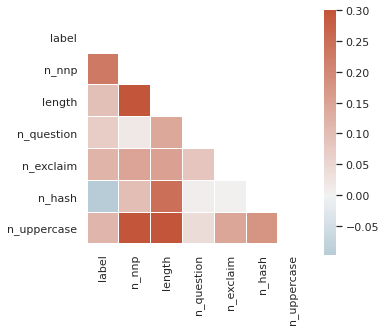

In [24]:
plot_correlation_matrix(tweets_and_users[["label", "n_nnp", "length", "n_question", "n_exclaim", "n_hash", "n_uppercase"]])

The next boolean features indicate whether the content of the Tweet is subject to certain features. We hypothesize for example that misinformation Tweets might contain malicious links or articles to news articles with questionable sources. This should mean that Tweets that do not contain links, should be more trustworthy and less likely to be misinformation.  

We can easily compute the F1-score to quickly see whether the booleans coincide (or do not) with that of the label. As easy as it is. At the same time, it is a dangerous assumption as a high F1-score does not necessarily prove anything. The F1-score could be high coincidentally and would not necessarily mean that it is useful. This was an assumption (and a big mistake) that was made in the very beginning. For detecting correlation, we should consider plotting the correlation matrix (or any other useful plot). 

In [25]:
print(f1_score(tweets_and_users["has_link"], y))
print(f1_score((~tweets_and_users["subjective"].astype(bool)).astype(int), y))
print(f1_score((tweets_and_users["possibly_sensitive"].astype(bool)).astype(int),y))

0.6348720800889878
0.6307394502516455
0.06461974492205952


We can see above that the feature "subjective" has a high F1-score when compared with the label. In that case, a Tweet being not "subjective" (and thus objective), would likely be misinformation. Ofcourse, if for a second we consider that this is not a dangerous assumption, then we could reason that misinformation Tweets are likely to be objective because they happen to claim more. While this sounds reasonable, it can not be assumed, let alone be generalized. And indeed, when we look at the correlation matrix, we can see that there is not a significant correlation with a Tweet being "subjective" and its associated label. 

The feature "has_link" does seem to (rather strongly) correlate negatively with the label. This means that our hypothesis was in fact true (or atleast somewhat accurate). The same cannot be said for the label "possibly_sensitive" as this shows a very weak (positive) correlation. 

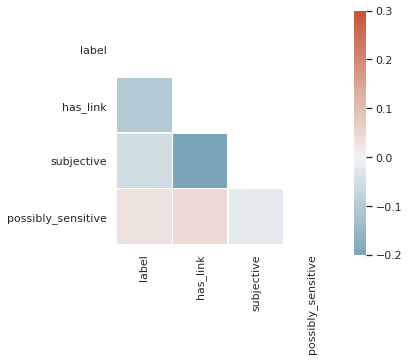

In [26]:
plot_correlation_matrix(tweets_and_users[["label","has_link", "subjective", "possibly_sensitive"]])

### Sources

#### Platform source

We can also look at the feature "source" of the Tweet, which indicates from which device or platform the Tweet was posted. Below, we print each source (originally in HTML format) and the occurence amount (on the right). We can see that though users who posted misinformation were more likely to post their Tweet from a mobile application, the difference is not staggering. Both types of Tweets are posted from a variety of different sources and platforms. Misinformation Tweets can thus not be linked to a set of sources that we could be consider less trustworthy. 

In [27]:
print("Sources of misinformation Tweets")
print()
tweets_and_users.loc[tweets_and_users["label"] == 1, "source"].value_counts()[0:20]

Sources of misinformation Tweets



<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      2616
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      2569
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                 2201
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    1373
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>        501
<a href="http://publicize.wp.com/" rel="nofollow">WordPress.com</a>                       86
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       82
<a href="https://dlvrit.com/" rel="nofollow">dlvr.it</a>                                  53
<a href="https://www.hootsuite.com" rel="nofollow">Hootsuite Inc.</a>                     48
<a href="https://ifttt.com" rel="nofollow">IFTTT</a>                                      47
<a href="https://buffer.com" rel="nofollow">Buffer</a>                

In [28]:
print("Sources of trustworthy Tweets")
print()
tweets_and_users.loc[tweets_and_users["label"] == 0, "source"].value_counts()[0:20]

Sources of trustworthy Tweets



<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      2728
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      1422
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                 1370
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>     858
<a href="https://dlvrit.com/" rel="nofollow">dlvr.it</a>                                 489
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>        318
<a href="https://www.hootsuite.com" rel="nofollow">Hootsuite Inc.</a>                    288
<a href="https://ifttt.com" rel="nofollow">IFTTT</a>                                     282
<a href="http://publicize.wp.com/" rel="nofollow">WordPress.com</a>                      282
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      191
<a href="https://buffer.com" rel="nofollow">Buffer</a>                

#### URL Source

Next, we will look at the source of the URLs that are posted along with the Tweet. 

In [29]:
urls_real = []
urls_fake = []
shortened_urls= ['bit.ly', 'ow.ly', 'buff.ly', 'ift.tt', 'is.gd', 'trib.al', 'goog.le', 'twitter.com']

for i, k in tweets_and_users.loc[tweets_and_users["label"] == 0].iterrows():
  for u in k["entities"]["urls"]:
    u2= u["expanded_url"].split('/')[2]
    if (u2 not in shortened_urls):
      urls_real.append(u2)

for i, k in tweets_and_users.loc[tweets_and_users["label"] == 1].iterrows():
  for u in k["entities"]["urls"]:
    u2 = u["expanded_url"].split('/')[2]
    if (u2 not in shortened_urls):
      urls_fake.append(u2)

Below, we can see list of sources (sorted descending on frequency of mention). Some of these sources are known to be common spreaders of untrustworthy information or sources of controversial content. However, we have to consider the fact that this list does not contain only untrustworthy media. For example, "cnbc.com" which most people consider could reliable. It so happens to be that people will likely use URL's to make a point and that their Tweet might be labeled as misinformation for other reasons. That's why we also have to collect more reliable sources and take these into consideration in addition with other contextual features. 

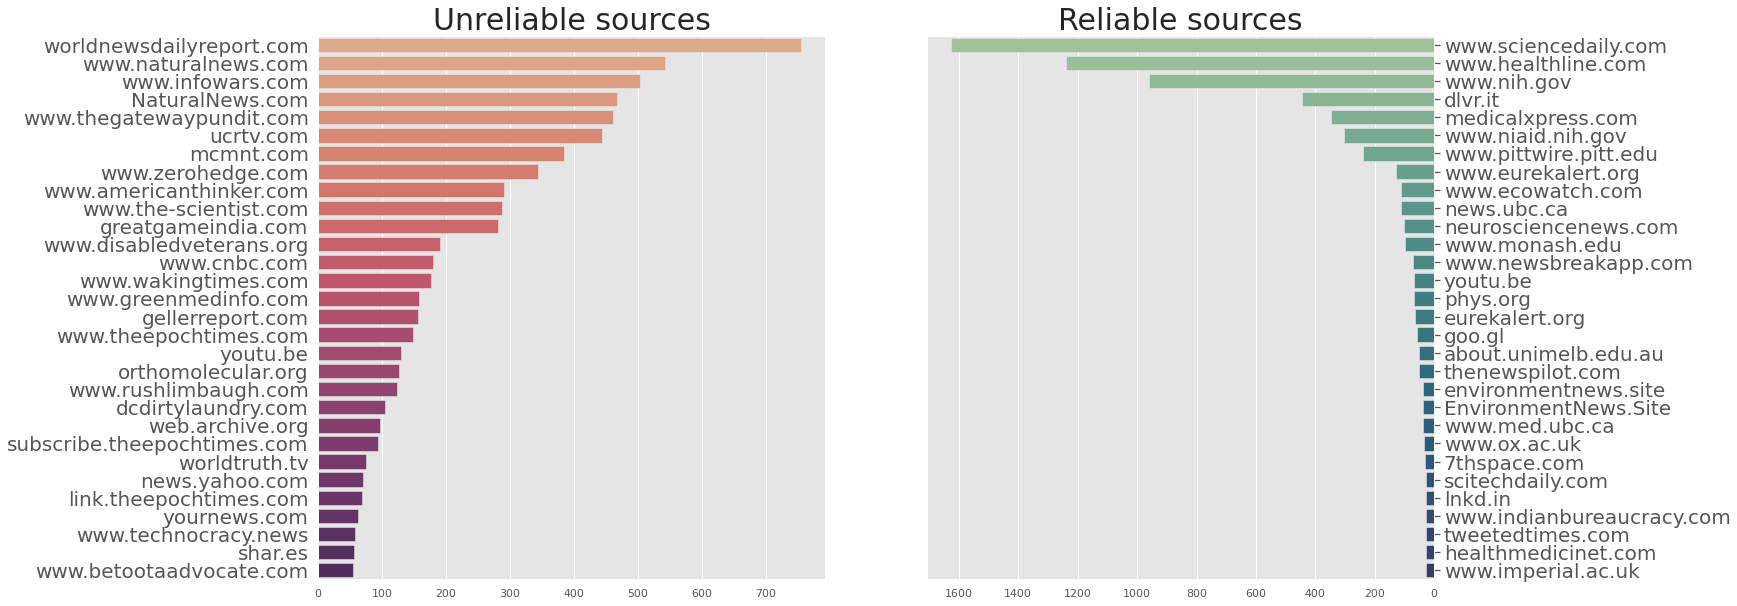

In [141]:
top_sources_fake = []
top_sources_fake_c = []

top_sources_real = []
top_sources_real_c = []

for h in set(urls_fake):
  top_sources_fake.append(h)
  top_sources_fake_c.append(urls_fake.count(h))

for h in set(urls_real):
  top_sources_real.append(h)
  top_sources_real_c.append(urls_real.count(h))

sources_real = [x for _,x in sorted(zip(top_sources_real_c,top_sources_real))]
sources_real.reverse()
sources_real = sources_real[0:30]
sources_real_c = sorted(top_sources_real_c, reverse=True)[0:30]

sources_fake = [x for _,x in sorted(zip(top_sources_fake_c,top_sources_fake))]
sources_fake.reverse()
sources_fake = sources_fake[0:30]
sources_fake_c = sorted(top_sources_fake_c, reverse=True)[0:30]

with plt.style.context('ggplot'):
  f = plt.figure(figsize=(20,10))
  ax0 = plt.subplot(121)
  sns.barplot(ax=ax0, y=sources_fake, x=sources_fake_c, palette="flare")
  plt.title('Unreliable sources',fontsize=30)
  plt.yticks(fontsize=20)

  ax1 = plt.subplot(122)
  sns.barplot(ax=ax1, y=sources_real, x=sources_real_c, palette="crest")
  plt.title('Reliable sources',fontsize=30)
  ax1.yaxis.set_ticks_position("right")
  plt.yticks(fontsize=20)
  ax1.invert_xaxis()
  plt.savefig('Junk/sources.jpg', bbox_inches='tight')
  plt.show()


And similarly as above, we collect a list of more reliable and trustworthy media sources. Note that this list might contain unreliable sources due to mislabeling of the dataset. 

We will create a new feature "has_bad_source" that will be 1 if the one of the links that a Tweet contains (if and only if) belongs to the misinformation sources. We will then look whether this positively correlates with our label. In fact, it strongly correlates with the label meaning that we can use this feature for training our classifier.  

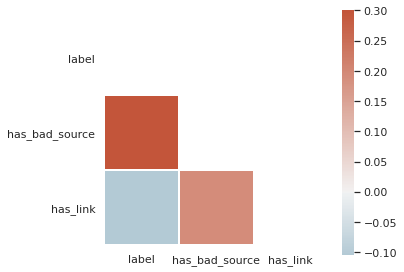

In [31]:
tweets_and_users.loc[:, "has_bad_source"] = 0

for i, k in tweets_and_users.iterrows():
  for u in k["entities"]["urls"]:
    url = u["expanded_url"].split('/')[2]
    if (url in top_sources_fake and url not in top_sources_real):
      tweets_and_users.loc[i, "has_bad_source"] = 1
    tweets_and_users.loc[i, "source"] = url

plot_correlation_matrix(tweets_and_users[["label", "has_bad_source", "has_link"]])

### User characteristics

Rather than looking at the Tweet level features, we might look at the data and metadata of the users and see whether these contain useful features to distinguish misinformation. 

Below, we can see that the feature "followers_friends_ratio" may be a good indicator of whether a Tweet will more likely to be misinformation. The followers_friends_ratio is the amount of followers a user has, divided by the amount of people following. For users that post misinformation, this ratio will be high meaning that they are likely to follow a lot more people that follow them back. This behavior is also very typical for social bots.

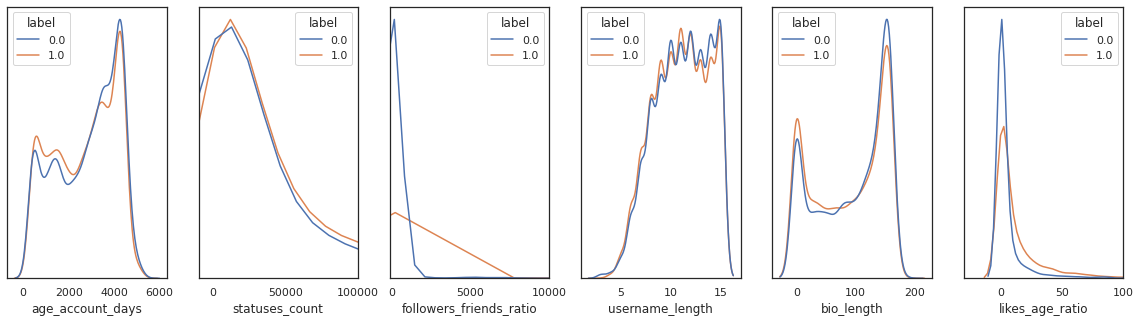

In [32]:
fig, axs = plt.subplots(ncols=6, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)
  
sns.kdeplot(data=tweets_and_users, x="age_account_days", hue="label", ax= axs[0])
sns.kdeplot(data=tweets_and_users, x="statuses_count", hue="label", ax= axs[1])
axs[1].set_xlim(-10000,100000)
sns.kdeplot(data=tweets_and_users, x="followers_friends_ratio", hue="label", ax= axs[2])
axs[2].set_xlim(-100,10000)
sns.kdeplot(data=tweets_and_users, x="username_length", hue="label", ax=axs[3])
sns.kdeplot(data=tweets_and_users, x="bio_length", hue="label",  ax=axs[4])
sns.kdeplot(data=tweets_and_users, x="likes_age_ratio", hue="label", ax=axs[5])
axs[5].set_xlim(-30,100)
print()

We also consider the boolean features.

Our first hypothesis for the boolean features is that users with a default profile (= users who "have not altered the theme or background of their user profile") are more likely to spread fake news. This could be true because of two reasons: both these feature indicates "new users" or users who do not use Twitter frequently, and these users may be more susceptible to sharing or posting fake news. Another reason could be that these users happen to be social bots, and were created at scale as "throwaway" accounts to spread misinformation for example. When we look at the correlation matrix, we can see that "default_profile" is indeed (mildly) positively correlated.

We see that users who have a URL in their Twitter profile, are more likely to spread misinformation. There is no specific hypothesis why this might be the case. This could be purely coincidence or because of an underlying reason. We will see later that this feature strongly correlates with a user being a social bot. In that case, we know that social bots are likely to spread misinformation and malicious content. Thus this could explain why it also correlates with the label "fake news" or "real news".  

Next, we look at the "protected" feature. When users are "protected", it means that their own statuses cannot be accessed by anyone who is not their friend. However, there happens to be no correlation with the label.

There happens to be a negative correlation in users being verified, and them spreading misinformation. There is an attractive hypothesis that non-verified users will more likely spread misinformation. It is a dangerous one considering that even verified users are prone to spreading misinformation. Perhaps as much as non-verified users (in general). It is dangerous to make the general assumption that verified users will not spread misinformation at the same rate as non-verified users. It seems reasonable to think that this might be true for some subset of trustworthy and verified users, or for this dataset. But this feature alone may not generalize very well for the entire population. 

The last feature "has_location" also happens to negatively correlate. But there is no viable explanation or hypothesis as to why this could be the case. Instead of trying to find a farfetched hypothesis, we would drop the feature altoghether. 

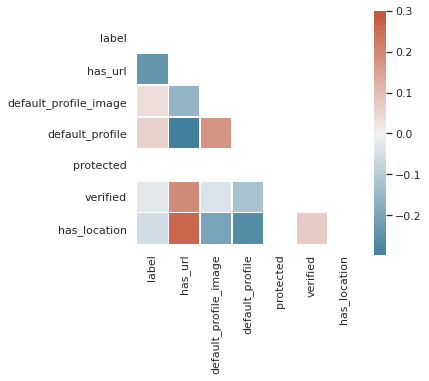

In [33]:
plot_correlation_matrix(tweets_and_users[["label", "has_url", "default_profile_image", "default_profile", "protected", "verified", "has_location"]])

### Opinion spam and duplication

In this subsection, we will find out how many Tweets are unique and how many have been retweeted or duplicated. The purpose of misinformation is to spread quickly in order to manipulate public opinion. One way this can be achieved is when a lot of users retweet one specific news article or claim. 

A naive way to do this is to listwise compare each Tweet content by cosine similarity. A high cosine similarity will usually indicate whether two Tweets contain similar content. We use cosine similarity rather than hashing because the content of the Tweet is likely to change when it has been retweeted. That is, new information will be added. By lowering the cosine similarity threshold, we can relax the similarity distance. However, if the threshold is too low (or too high), two Tweets might be dissimilar and the results will not be accurate. 

A hypothesis that we can try to confirm here is that misinformation Tweets will spread "more". That is, we should see less total amount of unique misinformation Tweets compared to "real" news.   

In [34]:
#https://gist.github.com/ahmetalsan/06596e3f2ea3182e185a

# compute the cosine similarity 
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

# turn Tweet content into a vector
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

# compute the cosine similarity of two Tweets
def get_result(text1, text2):
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine_result = get_cosine(vector1, vector2)
    return cosine_result


By default we ignore this computation because it takes a long time to run. You can enable it by changing the first condition to "True". 

The following algorithm will cluster Tweets that are similar in a dictionary. The length of the resulting dictionary of clusters will determine roughly how many unique Tweets each dataset (fake news and real news) is composed of. If we see that fake news Tweets contain less unique tweets than real news, then we can confirm the proposed hypothesis. 

The cosine similarity will have a significant effect on the clustering in that there will be a tradeoff between the cosine similarity and accuracy. If the cosine similarity is too high, then we will have smaller and more clusters and thus "many" uniques. This will be an overestimate of the ground truth. If the cosine similarity is too low, then we will have less clusters but larger in size. In that case, we will have an underestimate of amount of unique Tweets. Much like choosing the amount of K's in KNN algorithm, it is hard to define a good threshold. Because the algorithm is relatively slow, it is impossible to run many trials and pick a threshold accordingly. By trial and error, we pick a threshold of 0.9.   

In [ ]:
# tradeoff # clusters <-> # uniques found
# higher cosine similarity -> smaller and more clusters -> more uniques than ground truth
# lower cosing similarity -> larger and less clusters -> less uniques than ground truth
# what is a good cosine similarity threshold? We can only know if we inspect everything -> infeasible with 10K tweets
def calculate_uniques(df):
  print("Building cluster dictionary... This may take a while")
  cos_threshold = 0.9
  tweets_ = []

  for j,r in df.iterrows():
    tweets_.append(r['full_text'])

  book = defaultdict()
  for i, a in enumerate(tweets_):
    if (a != ""):
      to_join = []
      for j, b in enumerate(tweets_):
        if (i != j):
          if (b != ""):
            if (get_result(a,b) >= cos_threshold):
              to_join.append(j)
              tweets_[j] = ""
      if (len(to_join) > 0):
        book[i] = to_join
      else:
        book[i] = [i]
      tweets_[i] = ""

  c = 0
  for i, k in enumerate(book):
    if len(book[k]) > 0:
      c+=1

  print("# unique tweets before clusting: ", len(df))
  print("# unique tweets after clusting: ", c)
  print("Reduction of: ", int(((len(df)-c)/len(df))*100), "%")

  return book

if True:
  book_fake = calculate_uniques(tweets_fake)
  book_real = calculate_uniques(tweets_real)

print("Hypothesis = fake news spreads 'more' than real news")
print("Hypothesis is not true for this dataset. Both have similar reduction rates for a given cosine similarity.")

Building cluster dictionary... This may take a while
# unique tweets before clusting:  10000
# unique tweets after clusting:  4278
Reduction of:  57 %
Building cluster dictionary... This may take a while


Only half of the Tweets for both the "fake" and "real" news/claims were unique. The nature of Twitter (retweet) allows some Tweets to spread more effectively than others. This is actually very important because when a certain Tweet is labeled as misinformation, every other Tweet that is similar can also be labeled similarly. In this way, a large portion of Tweets can be labeled very efficiently. Especially when you know that millions of Tweets can possibly stem from one misinformed news or claim. 

Next, we can see which two Tweets in both the fake and real news Tweet dataset have been shared the most.  

In [ ]:
def get_most_spread(book):
  max_l = 0
  max_i = 0
  for i, k in book.items():
    if (len(k))> max_l:
      max_l = len(k)
      max_i = i
  return max_i

if True:
  print("Most shared fake news Tweet: ", tweets_fake['full_text'].loc[get_most_spread(book_fake)])
  print("Most shared real news Tweet: ", tweets_real['full_text'].loc[get_most_spread(book_real)])

In [ ]:
book_real_n = defaultdict()

for k, v in book_real.items():
  o = []
  for l in v:
    o.append((l+9999))
  book_real_n[(k+9999)] = o

book_real = book_real_n

In [ ]:
if True:
  for k, v in book_fake.items():
    tweets_and_users.loc[k, "cluster_size"] = 1 + len(v) 
    tweets_and_users.loc[k, "cluster_id"] = k
    for l in v:
      tweets_and_users.loc[l, "cluster_size"] = 1 + len(v) 
      tweets_and_users.loc[l, "cluster_id"] = k

  for k, v in book_real.items():
    tweets_and_users.loc[k, "cluster_size"] = 1 + len(v) 
    tweets_and_users.loc[k, "cluster_id"] = k
    for l in v:
      tweets_and_users.loc[l, "cluster_size"] = 1 + len(v) 
      tweets_and_users.loc[l, "cluster_id"] = k

### Hashtag occurence

Although word clouds are not desired way to visualize qualitative data (because they are confusing at best), they suffice for testing purposes. Here, we will visualize which hashtags are prominent in Tweets containing either "fake" and "real" news/claims. 

In [ ]:
# extract hashtags
tweets_and_users["hashtag"] = tweets_and_users["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))

# https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

too_obv = ["corona", "covid", "virus"]

# preprocessing hashtags
def clean_hashtags(content):
  words = content.split()
  result  = [word.lower() for word in words if not word.lower().strip().startswith(tuple(too_obv))]
  content = ' '.join(result)
  return content

def collect_hashtags(df):
  hashes = []
  for i, k in df.iterrows():
    for hash in k["hashtag"]:
      hashes.append(hash)
  return hashes


def frame_to_words(hashes):
  words = ""
  for hash in hashes:
    words += hash + " "
  return clean_hashtags(words)

hashes_fake = collect_hashtags(tweets_and_users[tweets_and_users["label"]==1])
hashes_real = collect_hashtags(tweets_and_users[tweets_and_users["label"]==0])

words = frame_to_words(hashes_fake)
w1 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)

words = frame_to_words(hashes_real)
w2 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)

Below, we can visualize the hashtags that were frequently used in both "fake news" and "real news". Note that there is some overlap between the hashtags used. 

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
fig.suptitle('Fake news hashtags (left)          Real news hashtags (right)', fontsize=22, fontweight='bold')
axs[0].imshow(w1)
axs[0].axis("off")
axs[1].imshow(w2)
axs[1].axis("off")
fig.set_facecolor("black")
print()

We will see whether the the occurence of a hashtag that frequently (and uniquely) occurs in misinformation Tweets, is somethow linked to misinformation. In order to this, we create a list of the most frequent Tweets used in misinformation.    

In [ ]:
top_hashes_fake = []

for h in set(hashes_fake):
  top_hashes_fake.append((hashes_fake.count(h), h))

top_hashes_fake = [k[1] for k in sorted(top_hashes_fake, reverse=True)[0:20]]

top_hashes_real = []

for h in set(hashes_real):
  top_hashes_real.append((hashes_real.count(h), h))

top_hashes_real = [k[1] for k in sorted(top_hashes_real, reverse=True)[0:20]]

# create a new column has_bad_tag
# this will be set to true if a hashtag occurs 
# (only) in the list of frequently used hashtags linked to misinformation
tweets_and_users.loc[:, "has_bad_tag"] = 0

for i, k in tweets_and_users.iterrows():
  for h in k["hashtag"]:
    if (h in top_hashes_fake and h not in top_hashes_real):
      tweets_and_users.loc[i, "has_bad_tag"] = 1

We see below that there is no strong correlation with our label and the fact that a Tweet contains a hashtag that is often used in Tweets labeled as misinformation. This might be due to the fact that there is too much overlap between the hashtags, and that not all Tweets necessarily contain hashtags.  

In [ ]:
plot_correlation_matrix(tweets_and_users[["label", "has_bad_tag"]])

## Social bot

We mentioned previously that social bots are notorious for spreading fake news. In other words, they are not a reliable source of information and can potentially be identified by a set of features and behaviors. In this subsection, we explore these features.

### User characteristics

In [ ]:
# we label bots with 1 and real users with 0
non_bots['label'] = 0
bots['label'] = 1
users = non_bots.append(bots, ignore_index=True)

Below, we can compare the distribution of the features related to bots and real accounts. The feature "likes_age_ratio" shows that bot accounts are likely to have a low ratio while real accounts have a higher ratio. A high ratio indicates a balanced amount of user activity over a amount of time since the user has created their account. A low ratio means that the user did not have significant amount of likes, even if their account was made a long time ago. This seems reasonable when we consider that most bot accounts are made for very specific yet malicious purposes (inflating follow counts, spreading Tweets,...). 

In [ ]:
fig, axs = plt.subplots(ncols=9, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)

sns.kdeplot(data=users, x="followers_friends_ratio", hue="label", ax= axs[0])
axs[0].set_xlim(-10,500)
sns.kdeplot(data=users, x="likes_age_ratio", hue="label", ax= axs[1])
axs[1].set_xlim(-3,9)
sns.kdeplot(data=users, x="favourites_count", hue="label", ax= axs[2])
axs[2].set_xlim(0,20000)
sns.kdeplot(data=users, x="statuses_count", hue="label", ax= axs[3])
axs[3].set_xlim(-100,100000)
sns.kdeplot(data=users, x="bio_length", hue="label", ax= axs[4])
sns.kdeplot(data=users, x="username_length", hue="label", ax= axs[5])
sns.kdeplot(data=users, x="name_length", hue="label", ax= axs[6])
sns.kdeplot(data=users, x="age_account_days", hue="label", ax= axs[7])
sns.kdeplot(data=users, x="listed_count", hue="label", ax= axs[8])
axs[8].set_xlim(0,300)
print()

**We** can see a significant difference between social bots and real users just by comparing the distributions alone. From the correlation matrix, their statistical significance becomes even more evident. 

This means that we can use most of these features to detect social bots. We have to be careful that these features do not cross-correlate, as this can have a negative impact on certain classifiers. In this case, evident cross-correlations are that of "favourites_count" and "statuses_count" or "name_length" and "username_length".  

In [ ]:
plot_correlation_matrix(users[["label", "followers_friends_ratio", "listed_count", "likes_age_ratio", "favourites_count", "statuses_count", "bio_length","username_length", "name_length", "age_account_days"]])

We will also consider the boolean features. We can see that there is a strong correlation between a real user and them not having a protected profile. The hypothesis here would be that unlike social bots, real users will not have to protect their profile from the public. Social bots are likely to do this to avoid being detected as a bot, because it would be easy to verify by inspecting their (malicious) activity such as posted or retweeted Tweets.

Next, we see that "has_url" positively correlates with the label. That is, users whose profile contains a URL are more likely to be social bots. A simple reason for this is that these bots contain malicious URLs or other URLs as means of sponsoring and advertisement. 

The "has_location" profile seems to strongly correlate with the label in that real users are likely to not have a location and vice versa, that social bots are more likely to have one. The reason for this could be that bot developers will want you to think that the bots are real users by providing them with an arbitrary location.

We expected the feature "verified" to strongly (negatively) correlate with the label. The "verified" status on Twitter is not a status that would be given by Twitter to social bots. Unfortunately, a majority of real users will also not have this status (because of its rarity) meaning that it is not a very useful one to distinguish social bots from real users. 

In [ ]:
plot_correlation_matrix(users[["label", "has_url", "protected", "default_profile", "has_location", "verified"]])

## Conclusion

In this section, we sought for useful features to detect misinformation. That is, features that were correlated strongly with the label "fake news" and "real news". We have considered both the API level features, their data mined counterparts and other (general) aspects of the data as well. We have seen that the social impact of a Tweet can be a strong indicator as misinformation had the tendency to be retweeted more. We have also seen that it is worth to look at semantic information of the Tweet, as this is where we will be able to mainly determine whether a Tweet can be considered as misinformation. In fact, some of the frequently mentioned URL sources in misinformation Tweets were very strongly correlated with the label. We also discovered that most of the Tweets were not unique. They usually stemmed from a specific Tweet. And lastly, we looked at difference between social bots and real users and have seen that they make up a large portion of the Twitter population. They cannot be ignored as their purposes are usually malicious. And the fact that they are not a reliable source means that we have to consider them during classification. In the next section, we will continue diving into the semantics of the Tweet content in order to find out whether we can distinguish fake news more effectively. We will work with a technique called TFIDF and train a classifier based on the resulting features. We will also train a social bot classifier based on the important features that we have collected so far. We will simultaneously dive into the most important aspect of this thesis, that is, explainable AI. As important as it is to predict misinformation and social bots, users must be able to trust these predictive models if they truly want to utilize them. One way we can endorse this is by explaining or otherwise "illuminating" the models such that users can understand how they work. 

# 7) Building a TFIDF classifier

In this section, we will train a classifier on TFIDF features. TFIDF is the product of the term frequence TF and inverse document frequency IDF. 

For term T:

- TF = number of occurence term T in document / total number of terms in document
- IDF = total number of documents / number of documents with term T 
- TFIDF = TF * IDF

The IDF is necessary to scale down the TFIDF score of words that occur in many documents. These are typically stop words that carry less important when classifying text. 

## Preparing documents

First, we have to collect the content of the different sources (news, claims, Tweets) of our dataset into one array of documents. We will clean the text before we process it any further.

In [103]:
# preprocessing helper
def remove_punct(text):
  text  = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

def remove_url(text):
  return re.sub(r"http\S+", "", text)

# preprocessing helper
def clean(content):
  words = content.split()
  content = ' '.join(words)
  content = remove_punct(content)
  content = remove_url(content)
  return content

In [104]:
def collect_from_sources(news, claims, tweets):
  content = []

  for i, cont in news.iterrows():
    content.append(clean(cont['content']))

  for i, cont in claims.iterrows():
    content.append(clean(cont['content']))

  for i, cont in tweets.iterrows():
    content.append(clean(cont['full_text']))
  
  return content

# array of documents
fake = collect_from_sources(fake_news_articles, fake_claims, tweets_fake)
real = collect_from_sources(real_news_articles, real_claims, tweets_real)

# and their respective label
y = np.concatenate((np.ones(len(fake), dtype=np.uint16), np.zeros(len(real), dtype=np.uint16)))

In [105]:
data = []

for f in fake:
  data.append(f)

real_ = random.sample(real, len(fake))
for r in real_:
  data.append(r)

y = y[0:len(data)]

# sanity check
print("We have", len(data), " documents in our array and", len(y), " corresponding labels")

We have 22888  documents in our array and 22888  corresponding labels


## Stemming + TFIDF features

In order to train the classifer with the TFIDF features, we must extract the features from the documents. We can use the TfidfVectorizer that will convert each document into a vector of features (terms). Below, we have chosen for a maximum of 2000 features. Although this is an arbitrary choice, we should limit this as this will determine the length of the vectors. We should avoid lengthy vectors due to the large number of features and the risk of including features that are just not that important. The vectorizer will pick the top 1000 features with the highest TF score. The documents will be converted into a vector of size 2000 where each entry (term) corresponds with the TFIDF score of that term (or multiple if we have > 1-grams).

We fit two vectorizers, one that allows 1-grams and another that only allows 2-grams or more. N-grams where n > 1 includes multiple neighbouring terms. The reason why we fit two vectorizers this way is to see the difference between the learned features and the performance. As you can probably guess, these features will be used to explain this whole process of classifying fake news by terms to users. The amount of n in n-grams may get in the way of providing understanding. 

We can also use a stemmer to remove certain affixes from words. For example: "owned" becomes "own" and "flying" becomes "fly". We do not apply a stemmer to the second vectorizer. We will explain why later. The vectorizer can also remove English stop words and other words that we want to determine. For the first vectorizer, we add words such as "coronavirus" and "pandemic" to the ignore list, because we know that they have a strong possibility to become features. However, they wouldn't make sense when predicting the difference between misinformation and factual information. We omit this process for the second vectorizer as these words may be used in combination with other important features, which is exactly what we want in n-grams where n > 1. 


In [106]:
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(["corona", "coronavirus", "coronaviru", "covid", "virus","people", "health", "new", "disease", "pandemic"])
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf_1gram = TfidfVectorizer(stop_words=stop_words,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        max_features=1000,
                        ngram_range=(1,2))

tfidf = TfidfVectorizer(stop_words='english',
                        use_idf=True,
                        max_features=1000,
                        ngram_range=(2,4))

X = tfidf.fit_transform(data)
X_1gram = tfidf_1gram.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'diseas', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'pandem', 'peopl', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'viru', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'your

In [107]:
features_1gram = tfidf_1gram.get_feature_names()
features = tfidf.get_feature_names()
len(features)

1000

## Feature visualization

We can visualize the TFIDF features that were determined. One way to do that is with wordclouds. 

In [108]:
def plot_cloud(words, label):
  
  if (label == "Fake"):
    !wget -P Junk "https://techcentral.co.za/wp-content/uploads/2019/05/donald-trump-2156-1120.jpg" -q
    mask = np.array(Image.open('Junk/donald-trump-2156-1120.jpg'))
  else:
    !wget -P Junk "https://static01.nyt.com/images/2014/08/10/magazine/10wmt/10wmt-superJumbo-v4.jpg" -q
    mask = np.array(Image.open('Junk/10wmt-superJumbo-v4.jpg'))
  
  return WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask).generate(words)


def plot_important_tfidf_features(matrix, label, feature_tfidf_threshold):

  f = np.zeros(len(features))

  for feature_vector in enumerate(matrix.todense()): 
    vector = np.array(feature_vector[1]).flatten()
    result = np.where(vector>=feature_tfidf_threshold)
    for i in result[0]:
      f[i] += 1

  words = ""
  for i, k in enumerate(f):
    if (k != 0):
      for _ in range(0,int(k)):
        words += " " + features_1gram[i]
  return plot_cloud(words, label)

w1 = plot_important_tfidf_features(X_1gram[:len(fake)], "Fake", 0.5)
w2 = plot_important_tfidf_features(X_1gram[len(fake):], "Real", 0.5)

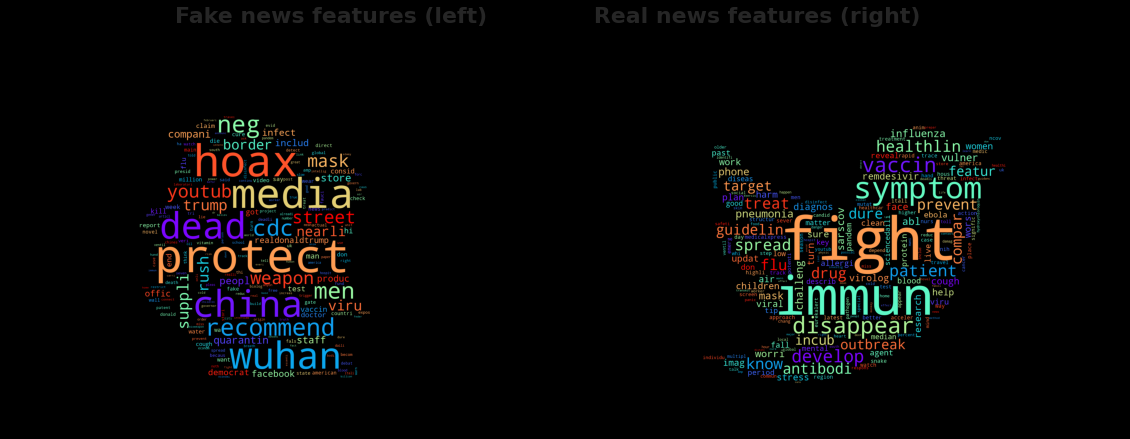

In [109]:
fig, axs = plt.subplots(ncols=2, figsize=(20,7))
fig.suptitle('Fake news features (left)              Real news features (right)', fontsize=22, fontweight='bold')

axs[0].imshow(w1)
axs[0].axis("off")
axs[1].imshow(w2)
axs[1].axis("off")
fig.set_facecolor("black")
print()

## Alternative visualizations

As you can see above, wordclouds are not a proper way to visualize qualitative information. They are confusing and bloated. In this subsection, we will look for alternative ways to display the TFIDF features. We will also consider the features of the vectorizer with n-grams where n > 1. A reason for this is that even though the word cloud above contains features such as "hoax" or "bioweapon" which may be useful to predict misinformation, they do not really make sense if we were to explain them to users. Terms that are used in combination may make more sense to users, especially if they denote a claim that a user can simply verify. 

The first alternative visualization is a word cloud that is supposed to be more organized, clear and one where size makes sense. That is, smaller sizes have smaller TFIDF scores.  

In [110]:
#https://gist.github.com/StevenMaude/ea46edc315b0f94d03b9
def get_scores(vectorizer, tfidf_result, amount):
  # http://stackoverflow.com/questions/16078015/
  tfidfs = np.asarray(tfidf_result.sum(axis=0)).ravel()
  scores = zip(vectorizer.get_feature_names(), tfidfs)
  #indices = sorted(zip(np.arange(0,1000,1), tfidfs), key=lambda x: x[1], reverse=True)
  #indices = [x[0] for x in indices]
  sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
  sorted_scores = sorted_scores[0:amount]
  a = [tup[0] for tup in sorted_scores]
  b = [tup[1] for tup in sorted_scores]
  return a, b

score_fake = get_scores(tfidf, X[0:(int(len(y)/2))], 20)
score_real= get_scores(tfidf, X[(int(len(y)/2)):], 20)

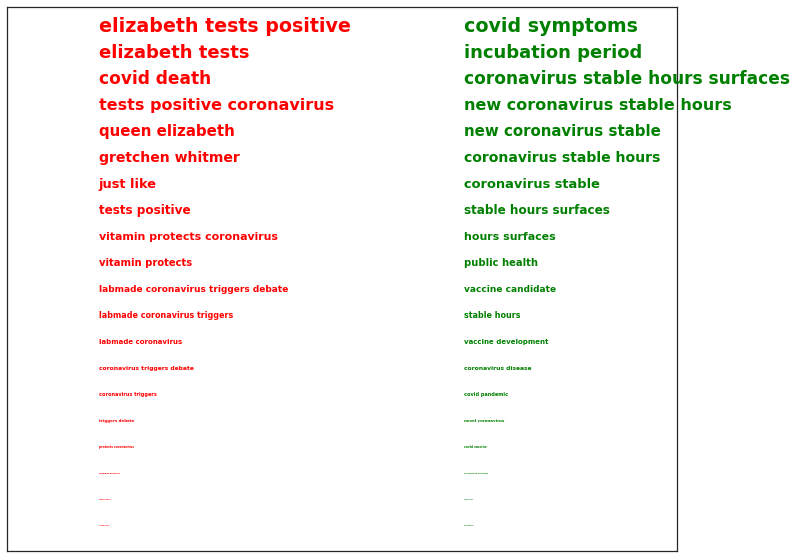

In [111]:
plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=([0] * 20), y=np.arange(0,20),size=np.zeros(20), sizes=(0,0))
ax.set(xticks=[], yticks=[])
ax.legend().set_visible(False)

c=0
# label points on the p
for x, z in zip(([-0.04] * 20), np.arange(0,20)):
 plt.text(x= x, y=z, color="red",s = score_fake[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1

c=0
# label points on the p
for x, z in zip(([0.02] * 20), np.arange(0,20)):
 plt.text(x= x, y=z, color="green", s = score_real[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1


Next, we visualize the same features with a bar chart.  

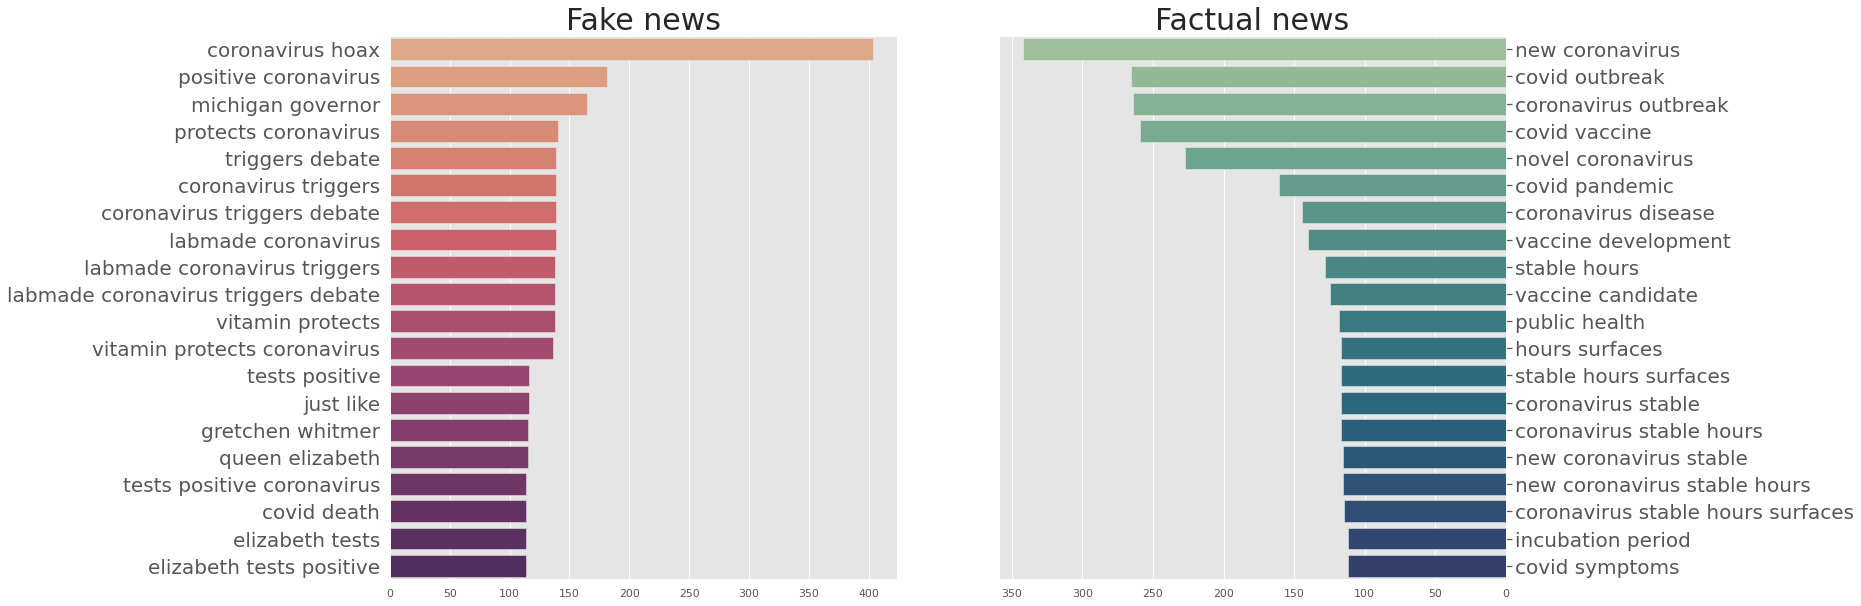

In [140]:
with plt.style.context('ggplot'):
  f = plt.figure(figsize=(20,10))
  ax0 = plt.subplot(121)
  sns.barplot(ax=ax0, y=score_fake[0], x=score_fake[1], palette="flare")
  plt.title('Fake news',fontsize=30)
  plt.yticks(fontsize=20)

  ax1 = plt.subplot(122)
  sns.barplot(ax=ax1, y=score_real[0], x=score_real[1], palette="crest")
  plt.title('Factual news',fontsize=30)
  ax1.yaxis.set_ticks_position("right")
  plt.yticks(fontsize=20)
  ax1.invert_xaxis()
  
  plt.savefig('Junk/tfidf.jpg', bbox_inches='tight')
  plt.show()

## Vector visualization

Previously, we have visualized the features that were deemed most important in the set of documents by the TFIDF vectorizer. We could argue that these features are important and that their presence will indicate whether or not a document can be labeled as "fake" or "real". By visualizing these features this way, it could somehow explain this concept easily to users who have no expert knowledge. However, this does not really make sense because some of these features in fake news for example could just as much be present in real news. We cannot look at the features this way. Instead, we should consider ALL the features (both their presence and absence). One way to do that is to look at the feature vector and what it represents. We can do that by plotting the vectors of all documents. 

Below, we visualize the matrix of the documents (in the Y-axis) and their vectors (in the X-axis). Each vector contains 2000 TFIDF values. In the plot below, a bright dot represents a high TFIDF value and a dark dot represents a low TFIDF value. We can see that the matrix is very sparse.  

The top half of the matrix (along the X-axis) contains the misinformation documents. We do not really see a consistent amount presence of features and the (high) occurences of features are chaotic. In the bottom half, we can actually see that some of the features are consistently reoccuring throughout the documents. We could actually visualize each vector in order to see how they map in the feature space. Unfortunately, the vectors are highly multi-dimensional. 

In [ ]:
# TFIDF matrix 
# y axis = document = string of words and characters 
# x axis = vector of features with elements = tfidf score --> brighter = higher

sns.heatmap(X_1gram.todense(), vmin=0, vmax=1, cbar=True)

PCA is a technique to reduce a high dimensional feature space to a smaller one. We can use TruncatedSVD from Sklearn to achieve this which uses Latent Semantic Analysis. TruncatedSVD will not center the data and works well with sparse matrices. Below, we will reduce the dimensions to 3 such that we can visualize the feature space in 3D.  

In [ ]:
def get_pca_vector(data):
  svd = TruncatedSVD(n_components=3, random_state=42)
  data2D = svd.fit_transform(X)
  d = pd.DataFrame(columns=["x", "y","z"])
  d["x"] = data2D[:,0]
  d["y"] = data2D[:,1]
  d["z"] = data2D[:,2]
  return d

In [ ]:
#http://blog.mahler83.net/2019/10/rotating-3d-t-sne-animated-gif-scatterplot-with-matplotlib/

!mkdir Out

ys = []

for k in y:
  if (k == 1):
    ys.append("red")
  else:
    ys.append("green")

d = get_pca_vector(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(d["x"], d["y"], d["z"], c=ys, s=1)

def rotate(angle):
     ax.view_init(elev=-30, azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=1)
ani.save('Out/pca.gif', writer=animation.PillowWriter(fps=20))
print()

We can clearly see below the difference between the vectors of documents that contain misinformation (red dots) and documents that do not (green dots). 

In [ ]:
from IPython import display
display.Image(open('Out/pca.gif','rb').read())

## Training white/black box model

We will train both a "white box" DecisionTree classifier and a "black box" RandomForest classifier. We will also train a "black box" classifier for the two vectorizers, one that contains 1-grams and more, and the one that only contains n-grams where n > 1. 

We can see that the white box classifier performs significantly worse than the black box classifier. We can also see that the blackbox with 1-grams performs a lot better. At this point, we have to consider whether we choose the very high performance but lack in explainability or give up some of the performance for more explainability. We choose the latter. 

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1gram, y, random_state=0, test_size=0.2, shuffle=True)


whitebox_tfidf = DecisionTreeClassifier(max_depth=3)
whitebox_tfidf.fit(X_train, y_train)
print("Whitebox DecisionTree F1 with depth 3: ", whitebox_tfidf.score(X_test, y_test))

# training a classifier for the two vectorizers to verify the difference in performance

blackbox_tfidf = RandomForestClassifier(n_estimators=20, max_depth=90).fit(X_train, y_train)
print("Blackbox RandomForest F1 score with 20 trees with depth 30: ", blackbox_tfidf.score(X_test, y_test))

blackbox_tfidf_1 = RandomForestClassifier(n_estimators=20, max_depth=90).fit(X_train_1, y_train_1)
print("Blackbox RandomForest F1 score with 20 trees with depth 30: ", blackbox_tfidf_1.score(X_test_1, y_test_1))

Whitebox DecisionTree F1 with depth 3:  0.5753604193971167
Blackbox RandomForest F1 score with 20 trees with depth 30:  0.9106596767147226
Blackbox RandomForest F1 score with 20 trees with depth 30:  0.9678899082568807


In [114]:
tweets_and_users["is_tfidf_fake"] = [k[1] for k in blackbox_tfidf.predict_proba(tfidf.transform(tweets_and_users["full_text"]))]

## Global understanding

Even though the "white box" classifier performs terrible, we can visualize it in order to understand how it works globally. Below, the nodes of the decision tree contain condition on which each node is split. That is, whether or not a specific term in the query has a TFIDF score smaller or equal to the presented value. Even though we refer to this classifier as white box, it does not mean that it is actually a white box model. For example, how would we explain this model to a non-expert user? We would have to explain what TFIDF means which in itself may confuse users and take a fair amount of time. Besides, we may not want to actually use nor explain this classifier in production mainly because of its low performance. If we decided to add more depth to the decision tree (to increase performance), it would become even harder to interpret the tree in a reasonable amount of time, even for experts. In that case, it might be easier to use the black box model and use model agnostic techniques to generate explanations for each prediction. We will use LIME in the next subsection to achieve this. That is, to generate local explanations.

mkdir: cannot create directory ‘Out’: File exists
White box model DecisionTree


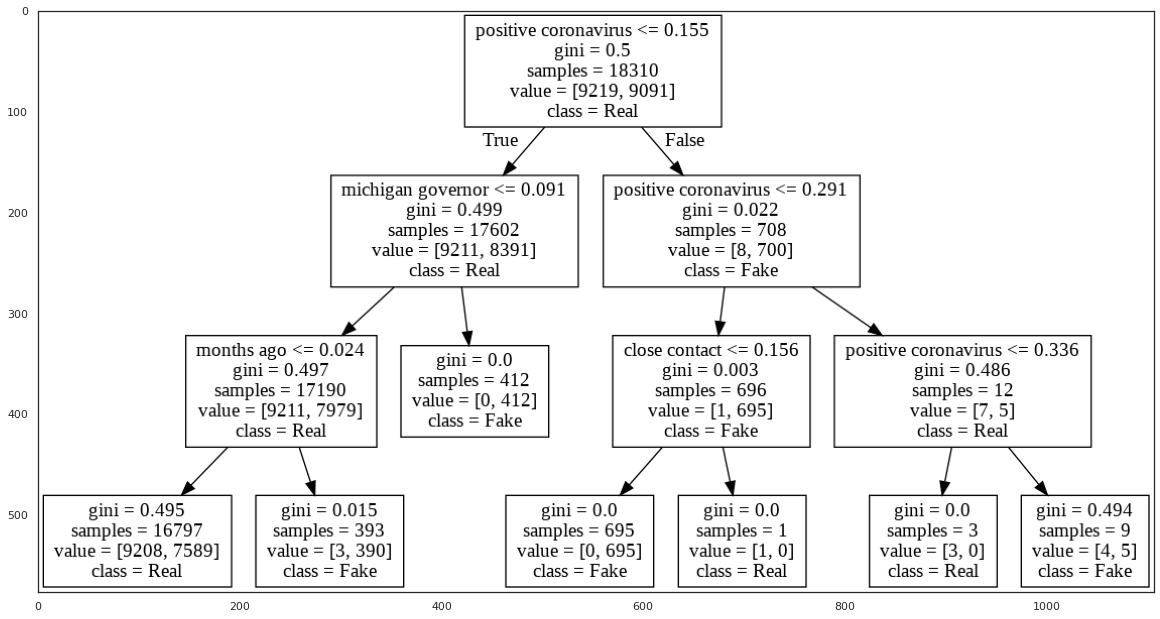

In [115]:
!mkdir Out
# Export as dot file
export_graphviz(whitebox_tfidf, out_file='Out/tree.dot', 
                feature_names = features,
                class_names = ["Real", "Fake"])

!dot -Tpng Out/tree.dot -o Out/tree.png

img = cv2.imread('Out/tree.png')
plt.figure(figsize = (20, 25))
print("White box model DecisionTree")
plt.imshow(img)

Let's try to solidify our understanding of the "white box" model above by considering an example sentence. We can follow the decision tree to see whether we can predict the label of the example sentence using the global "white box" model.

We start with the first node. The TFIDF score of "confirm" is not smaller than 0.154 (it's 0.43), thus we pick the right node. We pick the right node again because the TFIDF score of "case" is not smaller than 0.061. We stop on this node because the sentence does not contain the term in the node. The sentence then becomes labeled as "real". 

In [116]:
sentence = "there is a confirmed case of the virus in china"
v1 = tfidf.transform([sentence]).toarray()

def print_tfidf(vector):
  print("Features and TFIDF score: ")
  for i,k in enumerate(vector[0]):
    if k > 0:
      print("- ", features[i], k)

print_tfidf(v1)

print()
if (whitebox_tfidf.predict(v1)[0] == 1):
  print("Predicted as Fake")
else:
  print("Predicted as Real")

Features and TFIDF score: 

Predicted as Real


## Performance visualisation

We can plot the confusion matrix to get a better sense of the performance of the black box model. 

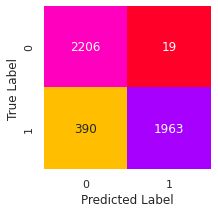

In [117]:
predictions = blackbox_tfidf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Local understanding (LIME)

We have trained a black box model previously and unlike the "white box" model, it has become much harder to explain the model globally. Thus, we can try to achieve a local understanding using LIME. This is a model agnostic technique that can help us to explain why a certain prediction was made by black box model. The explanation consists of a probability distribution, a list of the most important features (and their weights) that have contributed to the prediction as well as a heatmap of the text. Unfortunately, it is not possible to generate a LIME explanation for n-grams where n > 1. For its explanation we would have to find another way. 

We cannot use the 1-gram explanation below. First of all, the heatmap gives us no explanation to why it exactly the terms are highlighted. All we can infer is that they somehow contributed to the sentence being classified as fake. Although we know that the TFIDF scores of the occuring terms led to the prediction, a non-expert user will never be able to understand this. We can still use the visualization as a guide, but we must come up with an alternative explanation to explain why these terms are indicative of real or fake news. 

In [118]:
text = "there is a confirmed case of the virus in china"
tfidf_pipeline = make_pipeline(tfidf_1gram, blackbox_tfidf_1)
class_names = ["TRUE", "FAKE"]
tfidf_explainer = LimeTextExplainer(class_names = class_names)
exp = tfidf_explainer.explain_instance(text, tfidf_pipeline.predict_proba, num_features = 10)
fig = exp.show_in_notebook()

# 8) Building novel Twitter bot classifier

In this section, we will train a classifier to predict social bots. As mentioned previously, social bots are unreliable sources and are often deployed for malicious purposes. Detecting social bots can be a good way to indicate to users that they should not trust the Tweet. 

## Data preparation

In [119]:
# we pick the columns that we have analyzed before
columns = ["likes_age_ratio", "favourites_count", "username_length", "has_url", "age_account_days", "protected", "default_profile", "has_location"]

non_bots['label'] = 0
bots['label'] = 1
bot_data = non_bots.append(bots, ignore_index=True)
labels = bot_data['label']
bot_data = bot_data[columns]

X = bot_data.copy()
y = labels

bot_data["label"] = y

## Correlation matrix

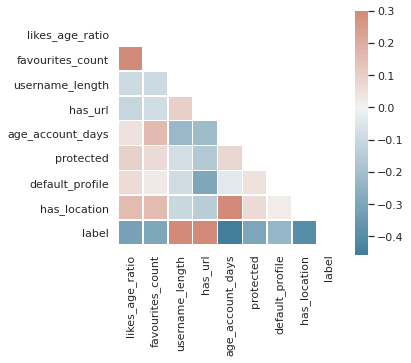

In [120]:
bot_corr = bot_data.corr()["label"]
bot_corr_label = columns
plot_correlation_matrix(bot_data)

## Training black box model

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

# baseline classifier
majority = np.zeros(len(y_test))
accuracy_score(majority, y_test)

0.512280701754386

In [122]:
# define the model
bot_model = RandomForestClassifier(n_estimators=13)

# fit the model
bot_model.fit(X_train,y_train)
preds = bot_model.predict(X_test)
f1_score(preds, y_test)

0.9710669077757685

## Confusion matrix

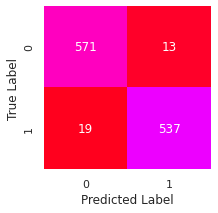

In [123]:
mat = confusion_matrix(y_test, preds)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True,   fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Local understanding (LIME)

Similarly as before, we can use LIME to explain the predictions.

In [124]:
i = 10
bot_explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), feature_names=X.columns, mode='classification')
exp = bot_explainer.explain_instance(X_test.iloc[i], bot_model.predict_proba)
print("Ground truth: ", y_test.iloc[i])
exp.show_in_notebook(show_table=True)

Ground truth:  0


# 9) Building misinformation classifier 

In this section, we will train a black box classifier on all the features that we have collected previously. 

## Data

In [125]:
columns = ["retweet_count","favorite_count","is_tfidf_fake", "has_bad_source", "subjective", "n_nnp", "n_exclaim", "n_hash", 'n_uppercase']
X = tweets_and_users[columns]
y = tweets_and_users['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

In [126]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

## Training

In [127]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_ = model.predict(X_test)
y_pred = model.predict(X)
f1_score(y_, y_test)

0.9882822238843181

## Performance

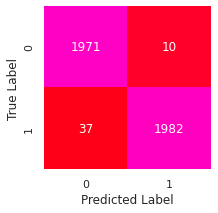

<Figure size 432x288 with 0 Axes>

In [128]:
mat = confusion_matrix(y_test, y_)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True,   fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('Junk/performance.jpg')

## Local understanding (LIME)

In [129]:
i = 43
misinformation_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns, mode='classification',class_names=["Real", "Fake"])
exp = misinformation_explainer.explain_instance(X_test.iloc[i], model.predict_proba)
print("Ground truth: ", y_test.iloc[i])
exp.show_in_notebook(show_table=True)

Ground truth:  1.0



# 10) Prepare data for study

For the user study, we will export 12 Tweets and split the Tweets in order to make sure that we have a balanced set. 

The final set will contain:
- 6 true positives 
- 6 true negatives

## Data selection

In [130]:
data = defaultdict()
tp = []
tn = []
fp = []
fn = []

for i, k in X_test.iterrows():
  if y[i] == 1 and y_pred[i] == 1:
    tp.append(i)
  if y[i] == 0 and y_pred[i] == 0:
    tn.append(i)
  if y[i] == 0 and y_pred[i] == 1:
    fp.append(i)
  if y[i] == 1 and y_pred[i] == 0:
    fn.append(i)

In [131]:
print("Number true positives:", len(tp))
print("Number true negatives:", len(tn))
print("Number false positives:", len(fp))
print("Number false negatives:", len(fn))

Number true positives: 1982
Number true negatives: 1971
Number false positives: 10
Number false negatives: 37


In [132]:
data["tp"] = random.sample(tp, 6)
data["tn"] = random.sample(tn, 6)

tp_ = [3394, 2345, 621, 7562, 1038, 1992]
tn_ = [13883, 13191, 13435, 16469, 14675, 17436]

if True:
  data["tp"] = tp_
  data["tn"] = tn_

for k in tp_:
  print(tweets_and_users.loc[k]["full_text"])

print()

for k in tn_:
  print(tweets_and_users.loc[k]["full_text"])

Belgium Health Minister puts ban on non-essential sexual activities of persons 3 or greater in indoor areas https://t.co/ZMcG0qoKIf
Vatican confirms Pope Francis and two aides test positive for Coronavirus - MCM https://t.co/5qDNabuyAU
#NewAdviceFromDrPhil 
If #Trump says "we oughta nuke a hurricane" or "ignore the coronavirus hoax," don't get cross with Trump like some in the media have a tendency to do https://t.co/TAUz0HZp9V
Lab-Made Coronavirus Triggers Debate | The Scientist Magazine®    https://t.co/VkSxAiaFo5
Royal Palace confirms Queen Elizabeth tests positive for coronavirus https://t.co/JFlSAZKAom
Hal Turner Radio Show - PROOF: The "Novel Coronavirus" Infecting the World is a MILITARY BIO-WEAPON Developed by China's Army https://t.co/Yztky8s2VK

Blog Post: Trial drug can significantly block early stages of COVID-19 in engineered human tissues - https://t.co/LV0jt4yZDo
Engineered virus might be able to block coronavirus infections, mouse study shows -- ScienceDaily https://t.c

# 11) Explanation pipeline

We will export the data points and their explanations in order to visualize it during the study

In [133]:
# collect our raw data
raw_data = []

for k, v in data.items():
  for p in v:
    raw_data.append(p)

raw_data = tweets_and_users.loc[raw_data]

# our complete parsed data including explanation data 
data_and_local_expl = []

## Local explanations

In [134]:
def get_neighbor_tweets(twid, prediction, cluster_id, model, columns):
  supporting = []
  against = []
  if (prediction == 1 and int(cluster_id) in book_fake.keys()):
    supporting = book_fake[int(cluster_id)]
    for k, v in book_real.items():
      if (get_result(tweets_and_users.loc[k]["full_text"],tweets_and_users.loc[twid]["full_text"]) >= 0.7):
        against = book_real[k]
  elif (prediction == 0 and int(cluster_id) in book_real.keys()):
    supporting = book_real[int(cluster_id)]
    for k, v in book_fake.items():
      if (get_result(tweets_and_users.loc[k]["full_text"],tweets_and_users.loc[twid]["full_text"]) >= 0.7):
        against = book_fake[k]
  twts = []
  if (twid in supporting) :
    supporting.remove(twid)
  if (twid in against) :
    against.remove(twid)
  for i, k in tweets_and_users.loc[supporting, :].iterrows():
    url = ""
    if (k["entities"]["urls"] != []):
      url = k["entities"]["urls"][0]["display_url"]
    twts.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"], int(np.argmax(model.predict_proba([k[columns]])[0])), url))
  return twts[0:30]

def get_neighbor_article(twid, prediction, article, model, columns):
  neighbors = []
  url = ""
  for i, k in shuffle(tweets_and_users).iterrows():
    if (k["entities"]["urls"] != []):
      url = k["entities"]["urls"][0]["display_url"]
    if (k["entities"]["urls"] != [] and k["entities"]["urls"][0]["display_url"] == article):
      if (prediction == k["label"]):
        neighbors.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"], int(np.argmax(model.predict_proba([k[columns]])[0])), url))
        if (len(neighbors) > 30):
          return neighbors[0:30]
  return neighbors[0:30]

def get_neighbor_source(twid, prediction, source, model, columns):
  neighbors = []
  for i, k in shuffle(tweets_and_users).iterrows():
    url = ""
    if (k["entities"]["urls"] != []):
      url = k["entities"]["urls"][0]["display_url"]
    if (k["entities"]["urls"] != [] and k["entities"]["urls"][0]["display_url"].split("/")[0] == source.split("/")[0]):
      if (prediction == k["label"]):
        neighbors.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"], int(np.argmax(model.predict_proba([k[columns]])[0])),url))
        if (len(neighbors) > 30):
          return neighbors[0:30]
  return neighbors[0:30]


def get_neighbor_popularity(twid, prediction, favorite_count, retweet_count, model, columns):
  neighbors = []
  for i, k in shuffle(tweets_and_users).iterrows():
    url = ""
    if (k["entities"]["urls"] != []):
      url = k["entities"]["urls"][0]["display_url"]
    if (prediction == k["label"]):
      if (abs(k["favorite_count"] - favorite_count) > 1000 and abs(k["favorite_count"] - favorite_count) < 100 or abs(k["retweet_count"] - retweet_count) < 100):
        neighbors.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"], int(np.argmax(model.predict_proba([k[columns]])[0])),url))
      elif (abs(k["favorite_count"] - favorite_count) < 10 or abs(k["retweet_count"] - retweet_count) < 10):
        neighbors.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"],int(np.argmax(model.predict_proba([k[columns]])[0])),url))
      if (len(neighbors) > 30):
        return neighbors[0:30]
  return neighbors[0:30]


def get_neighbor_style(twid, prediction, n_nnp, subjective, n_exclaim, n_hash, n_uppercase, model, columns):
  neighbors = []
  for i, k in shuffle(tweets_and_users).iterrows():
    url = ""
    if (k["entities"]["urls"] != []):
      url = k["entities"]["urls"][0]["display_url"]
    if (prediction == k["label"]):
      if (k["subjective"] == subjective and abs(k["n_hash"] - n_hash) <= 2 and abs(k["n_nnp"] - n_nnp) <= 3 and abs(k["n_exclaim"] - n_exclaim) <= 2 and abs(k["n_uppercase"] - n_uppercase) <= 2):
        neighbors.append((remove_url(k["full_text"]), k["screen_name"], k["name"], k["favorite_count"], k["retweet_count"], int(np.argmax(model.predict_proba([k[columns]])[0])), url))
      if (len(neighbors) > 30):
        return neighbors[0:30]
  return neighbors[0:30]

def build_local_explanations(i, dataframe):
  columns = ["retweet_count","favorite_count","is_tfidf_fake", "has_bad_source", "subjective", "n_nnp", "n_exclaim", "n_hash", 'n_uppercase']
  text = remove_url(dataframe["full_text"])
  dataframe["full_text"] = text
  datapoint = dataframe[columns]
  ground_truth = dataframe["label"]

  prediction = int(model.predict([datapoint])[0])


  neighbors_content = get_neighbor_tweets(i, prediction, dataframe.loc["cluster_id"], model, columns)
  neighbors_source = []
  neighbors_article = []
  if ("urls" in dataframe["entities"] and k["entities"]["urls"] != []):
    neighbors_source = get_neighbor_source(i, prediction, dataframe["entities"]["urls"][0]["display_url"], model, columns)
    neighbors_article = get_neighbor_article(i, prediction, dataframe["entities"]["urls"][0]["display_url"], model, columns)
  neighbors_popularity = get_neighbor_popularity(i, prediction, dataframe["favorite_count"], dataframe["retweet_count"], model, columns)
  neighbors_style = get_neighbor_style(i, prediction, dataframe["n_nnp"], dataframe["subjective"], dataframe["n_exclaim"], dataframe["n_hash"], dataframe["n_uppercase"],  model, columns)
  
  prediction_certainty = model.predict_proba([datapoint])[0]

  exp = misinformation_explainer.explain_instance(datapoint, model.predict_proba)
  exp_map = exp.as_map()[1]
  why_fake = []
  why_real = []

  total_weight = 0.00001

  for e_s, score in exp.as_list():
    total_weight += abs(score)

  c = 0
  for e_s, score in exp.as_list():
    if score > 0:
      why_fake.append((e_s, (abs(score)/total_weight), columns[exp_map[c][0]]))
    else: 
      why_real.append((e_s, (abs(score)/total_weight), columns[exp_map[c][0]]))
    c+=1

  why_tfidf_fake = []
  why_tfidf_real = []

  tfidf_grams = []

  for sent in features:
    if (sent in text):
      tfidf_grams.append(sent)
  
  print(tfidf_grams)

  prediction_tfidf = int(dataframe["is_tfidf_fake"])

  prediction_certainty_tfidf = blackbox_tfidf.predict_proba(tfidf.transform([clean(text)]))[0]

  exp = tfidf_explainer.explain_instance(text, tfidf_pipeline.predict_proba, num_features = 6)
  
  total_weight = 0.00001

  for e_s, score in exp.as_list():
    total_weight += abs(score)

  c = 0
  for e_s, score in exp.as_list():
    if score > 0:
      why_tfidf_fake.append((e_s, (abs(score)/total_weight)))
    else: 
      why_tfidf_real.append((e_s, (abs(score)/total_weight)))
    c+=1

  columns = ["likes_age_ratio", "favourites_count", "username_length", "has_url", "age_account_days", "protected", "default_profile", "has_location"]
  datapoint = dataframe[columns]
  prediction_bot = int(bot_model.predict([datapoint])[0])
  prediction_certainty_bot = bot_model.predict_proba([datapoint])[0]

  exp = bot_explainer.explain_instance(datapoint, bot_model.predict_proba)
  exp_map = exp.as_map()[1]


  why_bot = []
  why_not_bot = []

  total_weight = 0.0001

  for e_s, score in exp.as_list():
    total_weight += abs(score)

  c = 0
  for e_s, score in exp.as_list():
    if score > 0:
      why_bot.append((e_s, (abs(score)/total_weight), columns[exp_map[c][0]]))
    else: 
      why_not_bot.append((e_s, (abs(score)/total_weight), columns[exp_map[c][0]]))
    c+=1
  
  tweet = dataframe[["full_text", "retweet_count","favorite_count","is_tfidf_fake", "has_bad_source", "subjective",  "entities", "created_at_tweet"]] 
  user = dataframe[["name", "followers_count", "friends_count", "screen_name", "location", "description",  "verified", "url", "profile_image_url_https", "created_at_user", "statuses_count", "has_url", "likes_age_ratio", "favourites_count", "username_length", "age_account_days", "protected", "default_profile", "has_location"]]
  misinformation = {"prediction": prediction, "certainty": list(prediction_certainty), "why_fake": why_fake, "why_real": why_real}
  tfidf_ = {"prediction": prediction_tfidf, "certainty": list(prediction_certainty_tfidf), "why_fake":why_tfidf_fake, "why_real": why_tfidf_real, "tfidf_grams":tfidf_grams}
  bot = {"prediction": prediction_bot, "certainty":list(prediction_certainty_bot), "why_fake": why_bot, "why_real": why_not_bot}
  return {"tweet": tweet.to_json(), "truth":ground_truth, "user": user.to_json(), "neighbors_content": neighbors_content, "neighbors_source": neighbors_source, "neighbors_popularity": neighbors_popularity, "neighbors_style":neighbors_style, "neighbors_article":neighbors_article, "explanations": {"misinformation":misinformation, "tfidf":tfidf_, "bot":bot }}


In [135]:
data_and_local_expl = []

for i, k in raw_data.iterrows():
  data_and_local_expl.append(build_local_explanations(i, k))

['indoor areas', 'puts ban', 'sexual activities']
['aides test', 'aides test positive', 'test positive']
['coronavirus hoax']
[]
['tests positive']
[]
['block early', 'block early stages', 'early stages', 'engineered human', 'engineered human tissues', 'human tissues', 'significantly block', 'significantly block early', 'significantly block early stages']
['coronavirus infections', 'study shows']
['coronavirus drug', 'coronavirus drug identified', 'drug identified']
[]
[]
[]


## Extra explanations

In [136]:
!mkdir Explanations

globals = {}

# Charts
globals["corr"] = list(bot_corr)
globals["corr_label"] = list(bot_corr_label)

!mv Junk/socialimpact.jpg Explanations/
!mv Junk/sources.jpg Explanations/
!mv Junk/tfidf.jpg Explanations/

mkdir: cannot create directory ‘Explanations’: File exists
mv: cannot stat 'Junk/socialimpact.jpg': No such file or directory
mv: cannot stat 'Junk/sources.jpg': No such file or directory


## Export data for API

In [137]:
locals = {}
locals["A"]= [data_and_local_expl[k] for k in [0,1,2,6,7,8]]
locals["B"]= [data_and_local_expl[k] for k in [3,4,5,9,10,11]]

In [138]:
with open('Explanations/locals.json', 'w') as out:
    json.dump(locals, out)

with open('Explanations/globals.json', 'w') as out:
    json.dump(globals, out)

In [139]:
!zip -r explanations.zip Explanations

updating: Explanations/ (stored 0%)
updating: Explanations/locals.json (deflated 74%)
updating: Explanations/globals.json (deflated 33%)
updating: Explanations/sources.jpg (deflated 19%)
updating: Explanations/socialimpact.jpg (deflated 26%)
updating: Explanations/tfidf.jpg (deflated 25%)
